In [5]:
import re
import pickle
import pandas as pd
import numpy as np
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

In [8]:
df = pd.read_csv('../../data/Reviews.csv')

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df['Text'] = df['Text'] + ' ' + df['Summary']

In [10]:
# Delete unused columns
del df['Id']
del df['ProfileName']
del df['Summary']
del df['Time']
del df['ProductId']
del df['UserId']

In [11]:
df.loc[df['Score'] <= 3, 'ReviewSentiment'] = 0
df.loc[df['Score'] > 3, 'ReviewSentiment'] = 1

df['ReviewSentiment'] = df['ReviewSentiment'].astype(int)
#convert na to ""
df['Text'].fillna("", inplace=True)

In [12]:
def preprocess(s):
    # Remove html tags
    s = re.sub('<\S+>', '', s)
    # Replace urls with token
    s = re.sub(r'http:\S+', 'url', s)
    s = re.sub(r'https:\S+', 'url', s)
    
    s = s.lower()
    # Remove any other special characters
    s = re.sub(r'[^a-z ]', ' ', s)
    
    words = s.split()
    result = []
    
    # Remove stop words and lemmatize the words
    for word in words:
        if word in stop_words:
            continue
        word = lemmatizer.lemmatize(word)
        result.append(word)
    return ' '.join(result)

In [13]:
df['PreprocessText'] = df['Text'].apply(preprocess)
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,ReviewSentiment,PreprocessText
0,1,1,5,I have bought several of the Vitality canned d...,1,bought several vitality canned dog food produc...
1,0,0,1,Product arrived labeled as Jumbo Salted Peanut...,0,product arrived labeled jumbo salted peanut pe...
2,1,1,4,This is a confection that has been around a fe...,1,confection around century light pillowy citrus...
3,3,3,2,If you are looking for the secret ingredient i...,0,looking secret ingredient robitussin believe f...
4,0,0,5,Great taffy at a great price. There was a wid...,1,great taffy great price wide assortment yummy ...


In [14]:
negative = df[df['ReviewSentiment']==0]
positive = df[df['ReviewSentiment']==1]
print('Number of negative samples:', len(negative))
print('Number of positive samples:', len(positive))

Number of negative samples: 124677
Number of positive samples: 443777


In [15]:
positive_downsampled = resample(positive, replace=True, # sample with replacement
                                n_samples=len(negative), # match number in minority class
                                random_state=1)
print('Number of positive downsampled:', len(positive_downsampled))

downsampled = pd.concat([negative, positive_downsampled])
print('Total Number of rows after downsampling:', len(downsampled))

Number of positive downsampled: 124677
Total Number of rows after downsampling: 249354


In [11]:
# Delete unused objects
del stop_words
del lemmatizer
del negative
del positive

In [16]:
downsampled.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,ReviewSentiment,PreprocessText
1,0,0,1,Product arrived labeled as Jumbo Salted Peanut...,0,product arrived labeled jumbo salted peanut pe...
3,3,3,2,If you are looking for the secret ingredient i...,0,looking secret ingredient robitussin believe f...
12,1,1,1,My cats have been happily eating Felidae Plati...,0,cat happily eating felidae platinum two year g...
16,0,0,2,I love eating them and they are good for watch...,0,love eating good watching tv looking movie swe...
26,0,1,1,"The candy is just red , No flavor . Just plan...",0,candy red flavor plan chewy would never buy na...


# Sentiment
In this section we build an ensemble model that uses majority voting technique to predict the sentiment as well as helpfulness of reviews.
For more information on individual model training and train vs test data performance, see [SentimentAnalysisEnsemble.ipynb](../../classifier/SentimentAnalysisEnsemble.ipynb)

In the following section, we use the complete dataset for training using the chosen models to get the maximum accuracy from all the available data.

## Count Vectorizer + Logistic Regression

In [17]:
cv = CountVectorizer()
cv_fv = cv.fit_transform(downsampled['PreprocessText'])

We ran the GridSearch for logistic regression using various parameters and found the best parameters to be the following. A sample plot of the grid search is shown below.

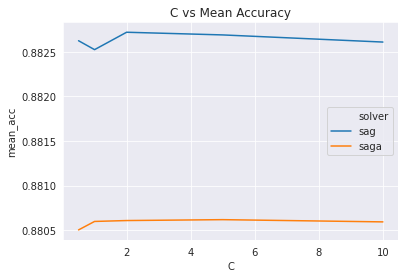

In [2]:
from IPython.display import Image
Image(filename='images/LR_GridSearch.png', width=500)

In [14]:
lr_cv = LogisticRegression(penalty='l2', random_state=1, C=2, solver='sag', max_iter=1000)
lr_cv.fit(cv_fv, downsampled['ReviewSentiment'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=2, max_iter=1000, random_state=1, solver='sag')

In [15]:
pickle.dump(lr_cv, open('model/senti_lr_cv', 'wb'))

In [18]:
lr_cv = pickle.load(open('model/senti_lr_cv', 'rb'))

## TF-IDF + Logistic Regression

In [19]:
tfidf = TfidfVectorizer()
tfidf_fv = tfidf.fit_transform(downsampled['PreprocessText'])

In [17]:
lr_tfidf = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_tfidf.fit(tfidf_fv, downsampled['ReviewSentiment'])

LogisticRegression(C=2, max_iter=1000, random_state=1, solver='sag')

In [18]:
pickle.dump(lr_tfidf, open('model/senti_lr_tfidf', 'wb'))

In [20]:
lr_tfidf = pickle.load(open('model/senti_lr_tfidf', 'rb'))

## Count Vectorizer + Naive Bayes
The following plot shows the search for alpha value.

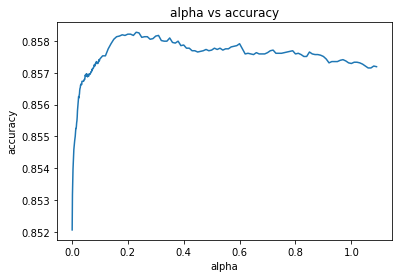

In [3]:
Image(filename='images/NB_alpha_search.png', width=500)

In [19]:
nb_cv = MultinomialNB(alpha=1.09)
nb_cv.fit(cv_fv,  downsampled['ReviewSentiment'])

MultinomialNB(alpha=1.09)

In [20]:
pickle.dump(nb_cv, open('model/nb_cv', 'wb'))

In [21]:
nb_cv = pickle.load(open('model/nb_cv', 'rb'))

## Ensemble Model - Sentiment

In [22]:
class MajorityVote:
    def __init__(self, classifiers):
        # These classifiers are already 'fit' with the training data
        self.classifiers = classifiers
    
    def predict(self, X):
        predictions = np.asarray([clf.predict(X[i])
                                      for i, clf in enumerate(self.classifiers)]).T
        
        maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x)),
                                      axis=1,
                                      arr=predictions)
        return maj_vote
    
    def score(self, X, y):
        pred_y = self.predict(X)
        correct = 0
        for i in range(len(y)):
            if pred_y[i] == y[i]:
                correct += 1
        acc = correct/len(y)
        return acc       

In [24]:
topic = "coffee"
df_filtered = df[df.Text.str.contains(topic,case=False)]
df_filtered.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,ReviewSentiment,PreprocessText
30,0,0,5,"I have never been a huge coffee fan. However, ...",1,never huge coffee fan however mother purchased...
38,0,0,4,I WAS VISITING MY FRIEND NATE THE OTHER MORNIN...,1,visiting friend nate morning coffee came stora...
54,2,2,4,I roast at home with a stove-top popcorn poppe...,1,roast home stove top popcorn popper outside co...
55,0,0,5,We roast these in a large cast iron pan on the...,1,roast large cast iron pan grill bag time smell...
82,15,15,5,I know the product title says Molecular Gastro...,1,know product title say molecular gastronomy le...


In [25]:
cv_filtered = cv.transform(df_filtered['PreprocessText'])
tfidf_filtered = tfidf.transform(df_filtered['PreprocessText'])

In [26]:
X = []
classifiers = []

classifiers.append(lr_cv)
X.append(cv_filtered)

classifiers.append(lr_tfidf)
X.append(tfidf_filtered)

classifiers.append(nb_cv)
X.append(cv_filtered)

mv = MajorityVote(classifiers)
mv_senti_pred = mv.predict(X)

# Helpfulness

In [27]:
# Get reviews that have atleast 5 votes
df_help = df[df['HelpfulnessDenominator'] >= 5]
# Compute helpfulness score
df_help['Helpfulness'] = df_help['HelpfulnessNumerator']/df_help['HelpfulnessDenominator']
# Remove data with errors - Numerator > demoninator
df_help['HelpDiff'] = df_help['HelpfulnessDenominator'] - df_help['HelpfulnessNumerator']
df_help[df_help['HelpDiff'] < 0]
# Get only the data with votes
df_help = df_help[df_help['HelpDiff'] >= 0]
df_help.loc[:, 'Helpful'] = np.where(df_help.loc[:, 'Helpfulness'] > 0.50, 1, 0)

del df_help['HelpfulnessNumerator']
del df_help['HelpfulnessDenominator']
del df_help['Score']
del df_help['HelpDiff']
del df_help['Helpfulness']

df_help.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,ReviewSentiment,PreprocessText,Helpful
14,The Strawberry Twizzlers are my guilty pleasur...,1,strawberry twizzlers guilty pleasure yummy six...,1
15,My daughter loves twizzlers and this shipment ...,1,daughter love twizzlers shipment six pound rea...,1
32,McCann's Instant Oatmeal is great if you must ...,1,mccann instant oatmeal great must oatmeal scra...,1
33,This is a good instant oatmeal from the best o...,1,good instant oatmeal best oatmeal brand us can...,1
34,Instant oatmeal can become soggy the minute th...,1,instant oatmeal become soggy minute water hit ...,1


## Logistic Regression using CountVectorizer

In [28]:
cv_help = CountVectorizer()
cv_help_fv = cv_help.fit_transform(df_help['PreprocessText'])

In [29]:
lr_cv_help = LogisticRegression(penalty='l2', random_state=1, max_iter=1500, C=2, solver='sag')
lr_cv_help.fit(cv_help_fv, df_help['Helpful'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=2, max_iter=1500, random_state=1, solver='sag')

In [30]:
pickle.dump(lr_cv_help, open('model/lr_cv_help', 'wb'))
lr_cv_help = pickle.load(open('model/lr_cv_help', 'rb'))

## Logistic Regression using TFIDF

In [31]:
tfidf_help = TfidfVectorizer()
tfidf_help_fv = tfidf_help.fit_transform(df_help['PreprocessText'])

In [32]:
lr_tfidf_help = LogisticRegression(penalty='l2', random_state=1, solver='sag', max_iter=1000, C=2)
lr_tfidf_help.fit(tfidf_help_fv, df_help['Helpful'])

LogisticRegression(C=2, max_iter=1000, random_state=1, solver='sag')

In [33]:
pickle.dump(lr_tfidf_help, open('model/lr_tfidf_help', 'wb'))
lr_tfidf_help = pickle.load(open('model/lr_tfidf_help', 'rb'))

## Naive Bayes using CountVectorizer

In [34]:
nb_cv_help = MultinomialNB(alpha=1.09)
nb_cv_help.fit(cv_help_fv, df_help['Helpful'])

MultinomialNB(alpha=1.09)

In [35]:
pickle.dump(nb_cv_help, open('model/nb_cv_help', 'wb'))
nb_cv_help = pickle.load(open('model/nb_cv_help', 'rb'))

## Use Ensemble model to extract helpful reviews of given sentiment and topic

In [36]:
# Replace topic with your topic and run the following cells
topic = "coffee"
df_filtered = df[df.Text.str.contains(topic,case=False)]

cv_filtered_senti = cv.transform(df_filtered['PreprocessText'])
tfidf_filtered_senti = tfidf.transform(df_filtered['PreprocessText'])

cv_filtered_help = cv_help.transform(df_filtered['PreprocessText'])
tfidf_filtered_help = tfidf_help.transform(df_filtered['PreprocessText'])

df_filtered.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,ReviewSentiment,PreprocessText
30,0,0,5,"I have never been a huge coffee fan. However, ...",1,never huge coffee fan however mother purchased...
38,0,0,4,I WAS VISITING MY FRIEND NATE THE OTHER MORNIN...,1,visiting friend nate morning coffee came stora...
54,2,2,4,I roast at home with a stove-top popcorn poppe...,1,roast home stove top popcorn popper outside co...
55,0,0,5,We roast these in a large cast iron pan on the...,1,roast large cast iron pan grill bag time smell...
82,15,15,5,I know the product title says Molecular Gastro...,1,know product title say molecular gastronomy le...


In [37]:
# Predict Sentiment
X = []
classifiers = []

classifiers.append(lr_cv)
X.append(cv_filtered_senti)

classifiers.append(lr_tfidf)
X.append(tfidf_filtered_senti)

classifiers.append(nb_cv)
X.append(cv_filtered_senti)

mv = MajorityVote(classifiers)
mv_senti_pred = mv.predict(X)

In [38]:
# Predict Helpfulness
classifiers = []
X = []

classifiers.append(lr_cv_help)
X.append(cv_filtered_help)

classifiers.append(lr_tfidf_help)
X.append(tfidf_filtered_help)

classifiers.append(nb_cv_help)
X.append(cv_filtered_help)

mv = MajorityVote(classifiers)
mv_help_pred = mv.predict(X)

# Get top 5 reviews for 'coffee' topic

In [47]:
def print_reviews(num_reviews=5, sentiment=1):
    review_text = df_filtered['Text'].tolist()
    count = 0
    for i, helpful in enumerate(mv_help_pred):
        if helpful == 1:
            if mv_senti_pred[i] == sentiment:
                print(review_text[i])
                print()
                count += 1
                if count == num_reviews:
                    break

# Print 5 reviews                    
print_reviews(sentiment=1)

I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :) Great machine!

I WAS VISITING MY FRIEND NATE THE OTHER MORNING FOR COFFEE , HE CAME OUT OF HIS STORAGE ROOM WITH ( A PACKET OF McCANNS INSTANT IRISH OATMEAL .) HE SUGGESTED THAT I TRY IT FOR MY OWN USE ,IN MY STASH . SOMETIMES NATE DOSE NOT GIVE YOU A CHANCE TO SAY NO , SO I ENDED UP TRYING THE APPLE AND CINN . FOUND IT TO BE VERY TASTEFULL WHEN MADE WITH WATER OR POWDERED MILK . IT GOES GOOD WITH O.J. AND COFFEE AND A SLICE OF TOAST AND YOUR READY TO TAKE ON THE WORLD...OR THE DAY AT LEAST